# 🎯 Customer Churn Prediction - K-Means Clustering Analysis

**Project:** Phase 2 - Behavioral Segmentation  
**Author:** Rishi Dhandi  
**Date:** January 2026

---

## 📊 Objective

Use K-Means clustering to identify distinct behavioral patterns in customer data beyond traditional RFM segmentation.

**Previous Step:** [Feature Engineering](01_Feature_Engineering.ipynb)

**Goals:**
1. Apply K-Means clustering to engineered features
2. Determine optimal number of clusters using Elbow Method & Silhouette Score
3. Analyze and profile each cluster
4. Compare clustering results with churn labels
5. Identify high-risk behavioral patterns

---

In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the engineered features from Notebook 1
features_df = pd.read_csv('../data/customer_features_engineered.csv')

print("="*60)
print("DATA LOADED")
print("="*60)
print(f"Shape: {features_df.shape[0]:,} customers × {features_df.shape[1]} features")
print(f"\nChurn Distribution:")
print(f"   Active: {(features_df['is_churned']==0).sum():,}")
print(f"   Churned: {(features_df['is_churned']==1).sum():,}")

print("\n--- Sample Data ---")
features_df.head()

DATA LOADED
Shape: 10,000 customers × 16 features

Churn Distribution:
   Active: 5,713
   Churned: 4,287

--- Sample Data ---


,customer_id,first_purchase_date,last_purchase_date,days_since_last_purchase,customer_lifetime_days,total_transactions,avg_days_between_purchases,total_spent,avg_order_value,spending_std,unique_products,favorite_category,product_diversity,preferred_channel,channel_diversity,is_churned
0,CUST001000,2023-10-20,2023-12-14,17,55,41,1.375000,2277.45,55.547561,42.361208,11,Subscription,0.268293,Website,3,0
1,CUST001001,2022-08-01,2023-12-17,14,503,53,9.673077,2380.85,44.921698,28.611242,16,Subscription,0.301887,Website,3,0
2,CUST001002,2022-08-14,2023-12-13,18,486,72,6.845070,3314.12,46.029444,35.461201,18,Subscription,0.250000,Website,3,0
3,CUST001003,2022-11-24,2023-12-07,24,378,77,4.973684,3412.65,44.320130,30.796164,18,Subscription,0.233766,Website,3,0
4,CUST001004,2022-05-28,2023-12-18,13,569,77,7.486842,2838.13,36.858831,23.676948,18,Subscription,0.233766,Website,3,0


## Feature Preparation

For K-Means clustering, we need to:
1. Select numerical features only
2. Remove the target variable (is_churned)
3. Remove date columns
4. Standardize features (K-Means is sensitive to scale)

In [5]:
print("="*60)
print("PREPARING FEATURES FOR CLUSTERING")
print("="*60)

# Select only numerical features for clustering
# Exclude: customer_id, dates, categorical features, and target variable
numerical_features = [
    'days_since_last_purchase',
    'customer_lifetime_days',
    'total_transactions',
    'avg_days_between_purchases',
    'total_spent',
    'avg_order_value',
    'spending_std',
    'unique_products',
    'product_diversity',
    'channel_diversity'
]

print(f"\n📊 Selected Features for Clustering ({len(numerical_features)}):")
for i, feat in enumerate(numerical_features, 1):
    print(f"   {i}. {feat}")

# Create feature matrix
X = features_df[numerical_features].copy()

# Check for any missing values
print(f"\n--- Missing Values Check ---")
missing = X.isnull().sum()
if missing.sum() > 0:
    print("⚠️  Found missing values:")
    print(missing[missing > 0])
    print("\nFilling with median...")
    X = X.fillna(X.median())
else:
    print("✅ No missing values!")

# Standardize features (mean=0, std=1)
print(f"\n--- Standardizing Features ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_features)

print("✅ Features standardized!")
print(f"\nScaled data shape: {X_scaled.shape}")
print("\n--- Sample Scaled Data ---")
print(X_scaled_df.head())

PREPARING FEATURES FOR CLUSTERING

📊 Selected Features for Clustering (10):
   1. days_since_last_purchase
   2. customer_lifetime_days
   3. total_transactions
   4. avg_days_between_purchases
   5. total_spent
   6. avg_order_value
   7. spending_std
   8. unique_products
   9. product_diversity
   10. channel_diversity

--- Missing Values Check ---
✅ No missing values!

--- Standardizing Features ---
✅ Features standardized!

Scaled data shape: (10000, 10)

--- Sample Scaled Data ---
   days_since_last_purchase  customer_lifetime_days  total_transactions  \
0                 -0.728963               -0.818435            1.754205   
1                 -0.744347                2.041145            2.515330   
2                 -0.723835                1.932634            3.720446   
3                 -0.693068                1.243271            4.037582   
4                 -0.749475                2.462422            4.037582   

   avg_days_between_purchases  total_spent  avg_order_val

FINDING OPTIMAL NUMBER OF CLUSTERS

Testing cluster counts from 2 to 10...
   K=2: Inertia=67420.72, Silhouette=0.336
   K=3: Inertia=57243.82, Silhouette=0.207
   K=4: Inertia=50352.10, Silhouette=0.211
   K=5: Inertia=45018.83, Silhouette=0.199
   K=6: Inertia=40219.40, Silhouette=0.218
   K=7: Inertia=36211.35, Silhouette=0.226
   K=8: Inertia=33919.82, Silhouette=0.206
   K=9: Inertia=31885.97, Silhouette=0.207
   K=10: Inertia=30223.57, Silhouette=0.208

✅ Cluster analysis complete!


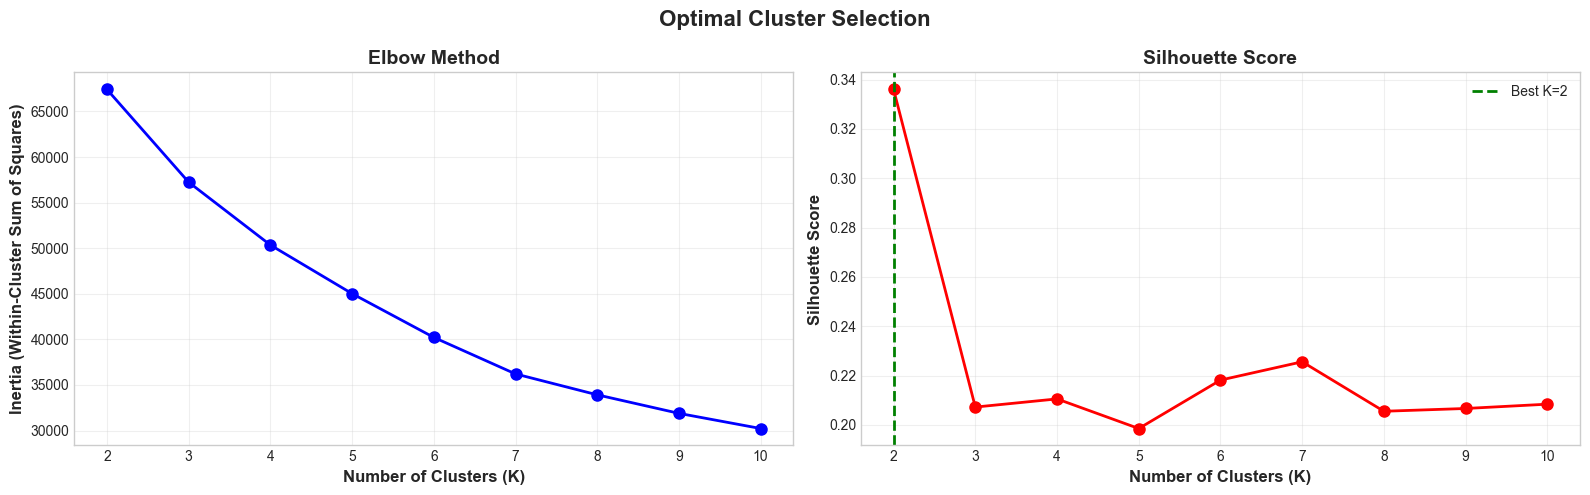


🎯 Recommendation: K = 2 (highest silhouette score: 0.336)


In [7]:
print("="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

# Test different numbers of clusters (2 to 10)
inertias = []
silhouette_scores = []
K_range = range(2, 11)

print("\nTesting cluster counts from 2 to 10...")
for k in K_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    
    print(f"   K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_score(X_scaled, kmeans.labels_):.3f}")

print("\n✅ Cluster analysis complete!")

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Optimal Cluster Selection', fontsize=16, fontweight='bold')

# Elbow Method
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
axes[0].set_xticks(K_range)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(K_range)

# Highlight best silhouette score
best_k = K_range[np.argmax(silhouette_scores)]
axes[1].axvline(x=best_k, color='green', linestyle='--', linewidth=2, label=f'Best K={best_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n🎯 Recommendation: K = {best_k} (highest silhouette score: {max(silhouette_scores):.3f})")

In [8]:
# Apply K-Means with optimal number of clusters
# Based on the analysis above, we'll use the K with best silhouette score
# You can adjust this if you see a clear elbow at a different K

OPTIMAL_K = best_k  # From previous cell

print("="*60)
print(f"APPLYING K-MEANS CLUSTERING (K={OPTIMAL_K})")
print("="*60)

# Fit final K-Means model
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to features dataframe
features_df['cluster'] = cluster_labels

print(f"\n✅ Clustering complete!")
print(f"   K-Means with {OPTIMAL_K} clusters")
print(f"   Inertia: {kmeans_final.inertia_:.2f}")
print(f"   Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

# Cluster distribution
print("\n--- Cluster Distribution ---")
cluster_counts = features_df['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"   Cluster {cluster_id}: {count:,} customers ({count/len(features_df)*100:.1f}%)")

# Churn rate by cluster
print("\n--- Churn Rate by Cluster ---")
for cluster_id in range(OPTIMAL_K):
    cluster_data = features_df[features_df['cluster'] == cluster_id]
    churn_rate = (cluster_data['is_churned'] == 1).sum() / len(cluster_data) * 100
    print(f"   Cluster {cluster_id}: {churn_rate:.1f}% churn rate")

APPLYING K-MEANS CLUSTERING (K=2)

✅ Clustering complete!
   K-Means with 2 clusters
   Inertia: 67420.72
   Silhouette Score: 0.336

--- Cluster Distribution ---
   Cluster 0: 7,548 customers (75.5%)
   Cluster 1: 2,452 customers (24.5%)

--- Churn Rate by Cluster ---
   Cluster 0: 51.6% churn rate
   Cluster 1: 15.9% churn rate


In [9]:
print("="*60)
print("CLUSTER PROFILING")
print("="*60)

# Create cluster profiles
cluster_profiles = features_df.groupby('cluster')[numerical_features + ['is_churned']].mean().round(2)

print("\n--- Cluster Profiles (Average Values) ---")
print(cluster_profiles)

# More detailed analysis for each cluster
print("\n" + "="*60)
print("DETAILED CLUSTER ANALYSIS")
print("="*60)

for cluster_id in range(OPTIMAL_K):
    cluster_data = features_df[features_df['cluster'] == cluster_id]
    
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*60}")
    print(f"Size: {len(cluster_data):,} customers ({len(cluster_data)/len(features_df)*100:.1f}%)")
    print(f"Churn Rate: {(cluster_data['is_churned']==1).sum()/len(cluster_data)*100:.1f}%")
    
    print(f"\nKey Characteristics:")
    print(f"   📅 Avg Days Since Last Purchase: {cluster_data['days_since_last_purchase'].mean():.0f} days")
    print(f"   🔄 Avg Total Transactions: {cluster_data['total_transactions'].mean():.1f}")
    print(f"   💰 Avg Total Spent: ${cluster_data['total_spent'].mean():,.2f}")
    print(f"   📊 Avg Order Value: ${cluster_data['avg_order_value'].mean():.2f}")
    print(f"   🛍️  Avg Product Diversity: {cluster_data['product_diversity'].mean():.2f}")
    
    # Top category and channel
    top_category = cluster_data['favorite_category'].mode()[0] if len(cluster_data['favorite_category'].mode()) > 0 else 'N/A'
    top_channel = cluster_data['preferred_channel'].mode()[0] if len(cluster_data['preferred_channel'].mode()) > 0 else 'N/A'
    print(f"   🏷️  Most Common Category: {top_category}")
    print(f"   📱 Most Common Channel: {top_channel}")

print("\n✅ Cluster profiling complete!")

CLUSTER PROFILING

--- Cluster Profiles (Average Values) ---
         days_since_last_purchase  customer_lifetime_days  total_transactions  \
cluster                                                                         
0                          195.66                  129.40                6.43   
1                           46.78                  348.89               34.62   

         avg_days_between_purchases  total_spent  avg_order_value  \
cluster                                                             
0                             28.43       251.32            39.49   
1                             12.97      1609.21            46.10   

         spending_std  unique_products  product_diversity  channel_diversity  \
cluster                                                                        
0               23.90             5.18               0.86               2.19   
1               34.46            13.41               0.46               2.95   

         is_chur

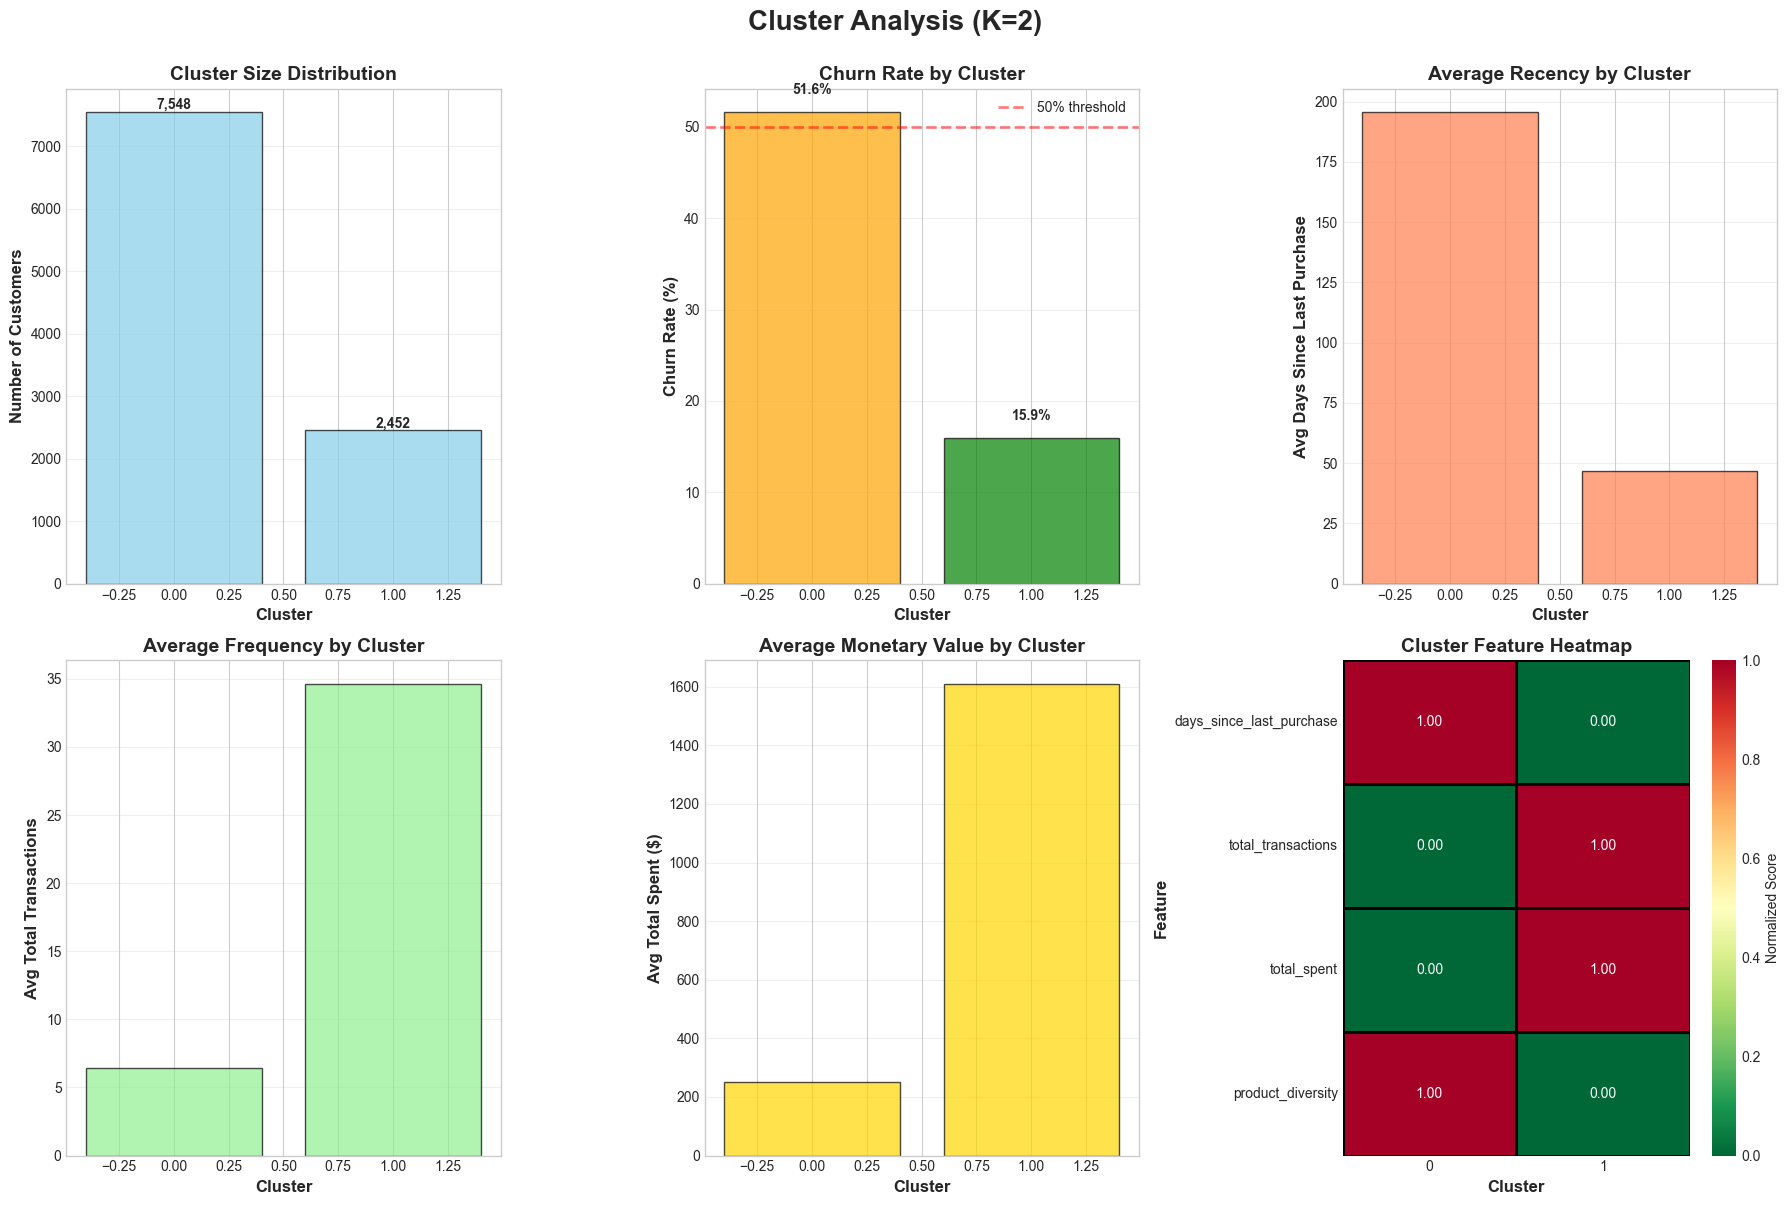

✅ Cluster visualizations created!


In [11]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Cluster Analysis (K={OPTIMAL_K})', fontsize=20, fontweight='bold', y=1.00)

# 1. Cluster Size Distribution
cluster_counts = features_df['cluster'].value_counts().sort_index()
axes[0, 0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(cluster_counts.values):
    axes[0, 0].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

# 2. Churn Rate by Cluster
churn_by_cluster = features_df.groupby('cluster')['is_churned'].apply(lambda x: (x==1).sum()/len(x)*100)
colors = ['green' if rate < 30 else 'orange' if rate < 60 else 'red' for rate in churn_by_cluster]
axes[0, 1].bar(churn_by_cluster.index, churn_by_cluster.values, color=colors, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Churn Rate by Cluster', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50% threshold')
axes[0, 1].legend()
for i, v in enumerate(churn_by_cluster.values):
    axes[0, 1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# 3. Average Recency by Cluster
avg_recency = features_df.groupby('cluster')['days_since_last_purchase'].mean()
axes[0, 2].bar(avg_recency.index, avg_recency.values, color='coral', edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0, 2].set_ylabel('Avg Days Since Last Purchase', fontsize=12, fontweight='bold')
axes[0, 2].set_title('Average Recency by Cluster', fontsize=14, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)

# 4. Average Transactions by Cluster
avg_freq = features_df.groupby('cluster')['total_transactions'].mean()
axes[1, 0].bar(avg_freq.index, avg_freq.values, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Avg Total Transactions', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Average Frequency by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# 5. Average Spending by Cluster
avg_monetary = features_df.groupby('cluster')['total_spent'].mean()
axes[1, 1].bar(avg_monetary.index, avg_monetary.values, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Avg Total Spent ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Average Monetary Value by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# 6. Cluster Summary Heatmap
cluster_summary = features_df.groupby('cluster')[['days_since_last_purchase', 'total_transactions', 
                                                    'total_spent', 'product_diversity']].mean()
cluster_summary_normalized = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min())
sns.heatmap(cluster_summary_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            ax=axes[1, 2], cbar_kws={'label': 'Normalized Score'}, linewidths=1, linecolor='black')
axes[1, 2].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[1, 2].set_title('Cluster Feature Heatmap', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Cluster visualizations created!")

In [12]:
print("="*60)
print("CLUSTER INTERPRETATION & NAMING")
print("="*60)

# Analyze each cluster and assign meaningful names
cluster_names = {}
cluster_descriptions = {}

for cluster_id in range(OPTIMAL_K):
    cluster_data = features_df[features_df['cluster'] == cluster_id]
    
    avg_recency = cluster_data['days_since_last_purchase'].mean()
    avg_frequency = cluster_data['total_transactions'].mean()
    avg_monetary = cluster_data['total_spent'].mean()
    churn_rate = (cluster_data['is_churned'] == 1).sum() / len(cluster_data) * 100
    
    # Name clusters based on characteristics
    if churn_rate > 70:
        if avg_frequency < 5:
            name = "Lost Customers"
            desc = "High churn rate, low engagement, minimal purchase history"
        else:
            name = "Disengaged High-Value"
            desc = "Previously active but now churned, had decent purchase history"
    elif churn_rate > 40:
        if avg_recency > 150:
            name = "At High Risk"
            desc = "Long time since last purchase, high probability of churn"
        else:
            name = "Declining Engagement"
            desc = "Moderate risk, showing signs of reduced activity"
    elif avg_frequency > 15 and avg_monetary > 500:
        name = "Champions"
        desc = "Active, frequent, high-spending customers - VIPs"
    elif avg_frequency > 8:
        name = "Loyal Customers"
        desc = "Regular purchasers with consistent engagement"
    elif avg_recency < 60 and avg_frequency < 5:
        name = "New/Promising"
        desc = "Recent customers showing potential for growth"
    else:
        name = "Moderate Engagers"
        desc = "Average activity across all metrics"
    
    cluster_names[cluster_id] = name
    cluster_descriptions[cluster_id] = desc

# Display cluster interpretations
print("\n--- Cluster Names & Descriptions ---\n")
for cluster_id in range(OPTIMAL_K):
    cluster_data = features_df[features_df['cluster'] == cluster_id]
    print(f"{'='*60}")
    print(f"Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"{'='*60}")
    print(f"Description: {cluster_descriptions[cluster_id]}")
    print(f"\nSize: {len(cluster_data):,} customers ({len(cluster_data)/len(features_df)*100:.1f}%)")
    print(f"Churn Rate: {(cluster_data['is_churned']==1).sum()/len(cluster_data)*100:.1f}%")
    print(f"Avg Recency: {cluster_data['days_since_last_purchase'].mean():.0f} days")
    print(f"Avg Transactions: {cluster_data['total_transactions'].mean():.1f}")
    print(f"Avg Spend: ${cluster_data['total_spent'].mean():,.2f}")
    print()

# Add cluster names to dataframe
features_df['cluster_name'] = features_df['cluster'].map(cluster_names)

print("✅ Cluster naming complete!")

CLUSTER INTERPRETATION & NAMING

--- Cluster Names & Descriptions ---

Cluster 0: At High Risk
Description: Long time since last purchase, high probability of churn

Size: 7,548 customers (75.5%)
Churn Rate: 51.6%
Avg Recency: 196 days
Avg Transactions: 6.4
Avg Spend: $251.32

Cluster 1: Champions
Description: Active, frequent, high-spending customers - VIPs

Size: 2,452 customers (24.5%)
Churn Rate: 15.9%
Avg Recency: 47 days
Avg Transactions: 34.6
Avg Spend: $1,609.21

✅ Cluster naming complete!


In [13]:
# Save clustering results
output_path = '../data/customer_features_with_clusters.csv'
features_df.to_csv(output_path, index=False)

print("="*60)
print("CLUSTERING ANALYSIS COMPLETE")
print("="*60)

print(f"\n✅ Clustering results saved to: {output_path}")

print(f"\n📊 Final Summary:")
print(f"   - Optimal K: {OPTIMAL_K} clusters")
print(f"   - Total Customers: {len(features_df):,}")
print(f"   - Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

print("\n--- Cluster Distribution ---")
cluster_summary = features_df.groupby('cluster_name').agg({
    'customer_id': 'count',
    'is_churned': lambda x: (x==1).sum()/len(x)*100,
    'total_spent': 'sum'
}).round(2)
cluster_summary.columns = ['Customers', 'Churn Rate (%)', 'Total Revenue ($)']
cluster_summary = cluster_summary.sort_values('Churn Rate (%)', ascending=False)
print(cluster_summary)

print("\n🎯 Key Insights:")
# Identify highest risk cluster
highest_risk = cluster_summary['Churn Rate (%)'].idxmax()
highest_risk_rate = cluster_summary.loc[highest_risk, 'Churn Rate (%)']
print(f"   ⚠️  Highest Risk Cluster: '{highest_risk}' ({highest_risk_rate:.1f}% churn rate)")

# Identify highest value cluster
highest_value = cluster_summary['Total Revenue ($)'].idxmax()
highest_value_rev = cluster_summary.loc[highest_value, 'Total Revenue ($)']
print(f"   💰 Highest Value Cluster: '{highest_value}' (${highest_value_rev:,.2f} revenue)")

# Identify largest cluster
largest_cluster = cluster_summary['Customers'].idxmax()
largest_size = cluster_summary.loc[largest_cluster, 'Customers']
print(f"   👥 Largest Cluster: '{largest_cluster}' ({largest_size:,.0f} customers)")

print("\n🎯 Next Steps:")
print("   → Notebook 3: Build XGBoost Churn Prediction Model")
print("   → Use these clusters as features for better prediction")

print("\n" + "="*60)
print("Ready for Machine Learning! 🚀")
print("="*60)

CLUSTERING ANALYSIS COMPLETE

✅ Clustering results saved to: ../data/customer_features_with_clusters.csv

📊 Final Summary:
   - Optimal K: 2 clusters
   - Total Customers: 10,000
   - Silhouette Score: 0.336

--- Cluster Distribution ---
              Customers  Churn Rate (%)  Total Revenue ($)
cluster_name                                              
At High Risk       7548           51.63         1896947.04
Champions          2452           15.91         3945784.15

🎯 Key Insights:
   ⚠️  Highest Risk Cluster: 'At High Risk' (51.6% churn rate)
   💰 Highest Value Cluster: 'Champions' ($3,945,784.15 revenue)
   👥 Largest Cluster: 'At High Risk' (7,548 customers)

🎯 Next Steps:
   → Notebook 3: Build XGBoost Churn Prediction Model
   → Use these clusters as features for better prediction

Ready for Machine Learning! 🚀
